# Final Project

Instrument classification based on its sound using Convolutional Neural Network.  
Please read the pdf in the github repo for more explanations.

In [1]:
import os
import librosa
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from python_speech_features import mfcc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential
from os import listdir
from os.path import isfile, join
import librosa
import scipy.signal as si
import scipy.io
from scipy.io import wavfile
import glob
import os
import pickle
import re

## Data Collection

For the dataset we decided to use IRMAS (https://www.upf.edu/web/mtg/irmas). A direct download link can be found here: https://zenodo.org/record/1290750/files/IRMAS-TrainingData.zip?download=1  
This dataset contains thousands of audio files representing musical and non-musical instruments (guitar, various sounds...).  
All the samples have a duration of exactly 3 seconds, which avoid us to have to normalize the samples size.  
For this project we restricted our training on 5 instruments: Piano, Voice, Electric Guitar, Trumpet and Clarinet.  

In [3]:
path='/Users/daniel/Documents/IDC/3rd Year/Sem 2/Music/project/IRMAS-TrainingData'
instrument_dir_list=[x[0] for x in os.walk(path)][1:]
cnt=0
files_dict={}
for instrument_dir in instrument_dir_list:
    wav_files = glob.glob(instrument_dir + '/*.wav')
    for i,wav in enumerate(wav_files):
        cnt+=1
        y, sr = librosa.load(wav)
        wav_name=wav.split('/')[-1].split(('.wav'))[0]
        genre=re.findall(r'\[(.*?)\]',wav_name)
        files_dict[cnt]=(wav_name,genre,y,sr)

print('Read {} samples'.format(cnt))

Read 3341 samples


In [4]:
def Check_Multi_Instument_Samples(loaded_dict):
    instruments=['pia','cla','flu','gac','gel','org','sax','tru','vio','voi']#,'dru','nod']
    choosen_instruments=['pia','voi','gel','tru','cla']#,'dru','nod']
    new_dict={}
    cnt=0
    for i in range(1,len(loaded_dict)):
        instrument_label=loaded_dict[i][1]
        c = len([i for i in instrument_label if i in instruments])
        b = len([i for i in instrument_label if i in choosen_instruments])
        if c==1 and b==1:
            classification=set(instrument_label).intersection(choosen_instruments)
            new_dict[i]=list(loaded_dict[i])
            new_dict[i][1]=classification.pop()
            cnt+=1
    print(cnt)
    return new_dict

In [5]:
files_dict_new=Check_Multi_Instument_Samples(files_dict)
df=pd.DataFrame.from_dict(files_dict_new).transpose()
df.rename(columns={0: "fname", 1: "label",2: "audio_waves", 3: "samplerate"},inplace=True)
print(df.head(5))

2700
                    fname label  \
3   [pia][jaz_blu]1490__3   pia   
5   [pia][jaz_blu]1524__1   pia   
8   [pia][jaz_blu]1459__1   pia   
11  [pia][pop_roc]1546__1   pia   
13  [pia][pop_roc]1295__2   pia   

                                          audio_waves samplerate  
3   [-0.012677529, -0.019334087, -0.017515492, -0....      22050  
5   [0.023276355, 0.044829205, 0.06683852, 0.08260...      22050  
8   [-0.025047539, -0.032104347, -0.020431772, -0....      22050  
11  [-0.00370622, -0.00057471474, 0.013650415, 0.0...      22050  
13  [0.031984247, 0.055895418, 0.05548825, 0.05385...      22050  


We will add 2 columns storing the length of each audio file, both in bits and seconds.  
To compute the second_lengths, we simply divide the number of all bits of each audio wave with the corresponding sample rate.

In [6]:
bit_lengths = list()
for i in range(df.shape[0]):
    bit_lengths.append(len(df['audio_waves'].iloc[i]))
bit_lengths = np.array(bit_lengths)
df['bit_lengths'] = bit_lengths
df['second_lengths'] = df['bit_lengths']/df['samplerate']
df.head()

,fname,label,audio_waves,samplerate,bit_lengths,second_lengths
3,[pia][jaz_blu]1490__3,pia,"[-0.012677529, -0.019334087, -0.017515492, -0....",22050,66150,3.0
5,[pia][jaz_blu]1524__1,pia,"[0.023276355, 0.044829205, 0.06683852, 0.08260...",22050,66150,3.0
8,[pia][jaz_blu]1459__1,pia,"[-0.025047539, -0.032104347, -0.020431772, -0....",22050,66150,3.0
11,[pia][pop_roc]1546__1,pia,"[-0.00370622, -0.00057471474, 0.013650415, 0.0...",22050,66150,3.0
13,[pia][pop_roc]1295__2,pia,"[0.031984247, 0.055895418, 0.05548825, 0.05385...",22050,66150,3.0


In [7]:
generated_audio_waves = np.array(df['audio_waves'])
generated_audio_labels = np.array(df['label'])
df['label'].value_counts()

voi    778
gel    753
pia    469
tru    418
cla    282
Name: label, dtype: int64

## Features preprocessing

In addition to the loudness we will take into account the pitch of the raw audio data.  
To be able to extract it we will use the Mel Frequency Cepstral Coefficients (MFCC).  
The mfcc_features variables contains the number of audio data and the heatmap image with the size of 275 times 13 produced using the mfcc() function.

Below you see the raw waveform and the heatmat of the second data sample.  
The heatmap image shows the frequency distribution within each time step. The darkest pixel represents lower energy and the lightest one shows higher energy.  
The classificiation will use those heatmaps in a similar way to images classificiation.

100%|██████████| 2700/2700 [00:09<00:00, 291.35it/s]


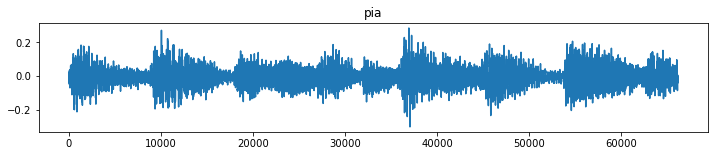

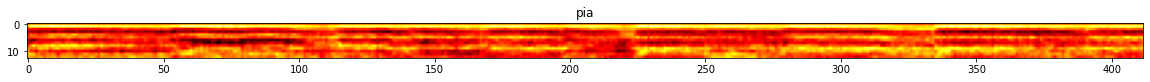

In [8]:
mfcc_features = list()
for i in tqdm(range(len(generated_audio_waves))):
    mfcc_features.append(mfcc(generated_audio_waves[i]))
mfcc_features = np.array(mfcc_features)

# Print a raw audio wave
plt.figure(figsize=(12,2))
plt.plot(generated_audio_waves[2])
plt.title(generated_audio_labels[2])
plt.show()

# Print the MFCC features of the audio wave
plt.figure(figsize=(20, 4))
plt.imshow(mfcc_features[2].T, cmap='hot')
plt.title(generated_audio_labels[2])
plt.show()

## Label preprocessing

Before constructing the net we label-encode and one-hot-encode the labels of each sample.
We have to do so because use categorical data (ex: samples have values clarinet, or saxophone...). Our net require all input variables and output variables to be numeric.  
As a first step, each unique category value is assigned an integer value (label-encoding). The integer values have a natural ordered relationship between each other and machine learning algorithms may be able to understand and harness this relationship.  
One-hot-encoding is used for categorical data with no ordinal relationship and we apply it to the integer representation.  
This is where the integer encoded variable is removed and a new binary variable is added for each unique integer value.

In [9]:
# Label encoding
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(generated_audio_labels)
label_encoded = label_encoded[:, np.newaxis]

# One hot encoding
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(label_encoded)

## Model training

Before training the model, I convert mfcc_features and one_hot_encoded into X and y respectively to make things look more intuitive. Next, I also normalize the values of all samples using standard normalization formula. Lastly, the data are split into train and test in which the test size is taken from 20% of the entire dataset. This train-test split is important to find out whether our model suffers overfitting. Below is the implementation of that:


### Why use CNN ?

It is considered as one of the best solution for image classification tasks. In our case we classify images in form of heatmaps.

### Net architecture

Since we are dealing with multiclass classification we use the categorical_crossentropy loss function.  
Regarding the optimizer we choosed Adam - as seen in homework 6 it is one of the best. It works with momentums of first and second order. It is ideal to train the neural network in less time and more efficiently.  
We are training the model with 30 epochs. This gave us an accuracy scores in the last epoch of roughly 76% and 72% towards training and testing data respectively.

In [11]:
X = mfcc_features
y = one_hot_encoded
X = (X-X.min())/(X.max()-X.min())

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Defining input shape for the neural network
# The 1 as the last argument is expected by Conv2D().
input_shape = (X_train.shape[1], X_train.shape[2], 1)

# Reshape X_train and X_test such that they are having the same shape as the input shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Constructing the neural network architecture
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), 
    padding='same', input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
     optimizer='adam',
     metrics=['acc'])

# Training the model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
68/68 [==============================] - 9s 129ms/step - loss: 1.6074 - acc: 0.2731 - val_loss: 1.5538 - val_acc: 0.2981
Epoch 2/30
68/68 [==============================] - 8s 120ms/step - loss: 1.5526 - acc: 0.2736 - val_loss: 1.4872 - val_acc: 0.3593
Epoch 3/30
68/68 [==============================] - 8s 115ms/step - loss: 1.5017 - acc: 0.3176 - val_loss: 1.4571 - val_acc: 0.4167
Epoch 4/30
68/68 [==============================] - 8s 115ms/step - loss: 1.4728 - acc: 0.3602 - val_loss: 1.3813 - val_acc: 0.4241
Epoch 5/30
68/68 [==============================] - 8s 115ms/step - loss: 1.4258 - acc: 0.3926 - val_loss: 1.4058 - val_acc: 0.4111
Epoch 6/30
68/68 [==============================] - 8s 113ms/step - loss: 1.3959 - acc: 0.4190 - val_loss: 1.2848 - val_acc: 0.5019
Epoch 7/30
68/68 [==============================] - 8s 115ms/step - loss: 1.3322 - acc: 0.4519 - val_loss: 1.2094 - val_acc: 0.5370
Epoch 8/30
68/68 [==============================] - 8s 114ms/step - loss: 1.

## Testing and Model Evaluation

We plotted the loss value and accuracy score in the two graphs below. We can see the improvements the model goes at every epochs.  
We can see that the loss values are decreasing as the the number of epoch increases. Hence the CNN classifier does not suffer of overfitting.

loss: 0.7623539566993713
val_loss: 1.0552783012390137


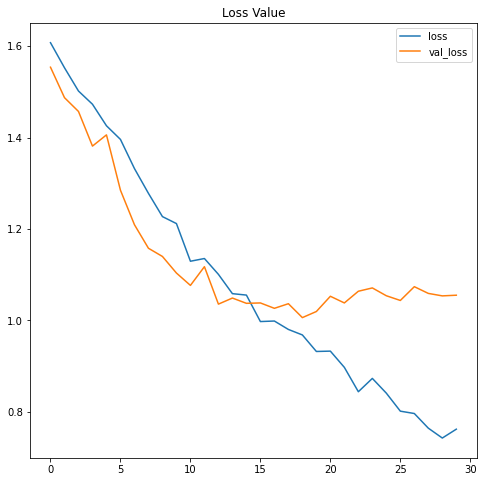

acc: 0.7263888716697693
val_acc: 0.6370370388031006


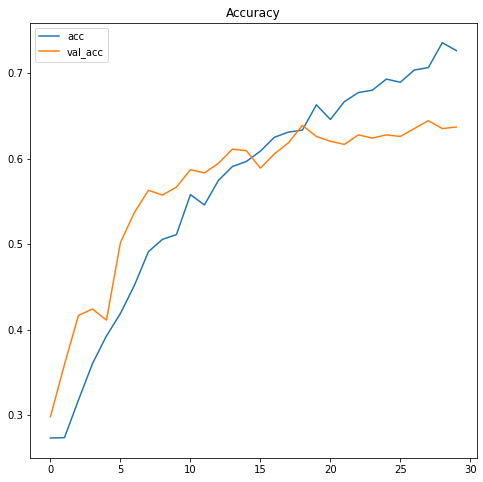

In [12]:
# Displaying loss values
plt.figure(figsize=(8,8))
plt.title('Loss Value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
print('loss:', history.history['loss'][-1])
print('val_loss:', history.history['val_loss'][-1])
plt.show()

# Displaying accuracy scores
plt.figure(figsize=(8,8))
plt.title('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
print('acc:', history.history['acc'][-1])
print('val_acc:', history.history['val_acc'][-1])
plt.show()

### Model Evaluation

We start by computing/predicting the probabilities for each sample in the test data `X_test` and then keep for each the instrument class with the highest probability.  
Then we decode y_test into the same form as `predictions` to compare the elemnts.

We are then able to evaluate the model performance with a confusion matrix using `predictions and y_test`.

Thanks to it we can see which class makes our CNN confused. The trumpet and the piano have the worst performances, while the electric guitar and the voice the best.  
Out of the 45 clavinet samples tested only 15 got correctly classified - mostly confused with piano and voice.  
After experimenting with various classes we saw that our model is not perfect and we optain mix result depending on the instruments.

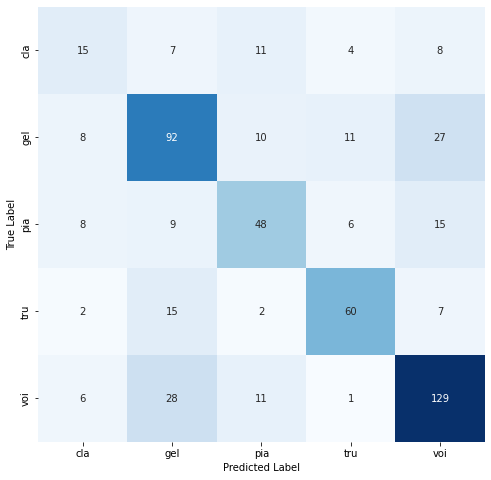

In [13]:
# We compute the probabilities
# For instance predictions[0] = [0.1,0.1,0.2,0.8,0.1] indicate that the class at index 3 has the highest probability.
predictions = model.predict(X_test)

predictions = np.argmax(predictions, axis=1) # We only keep the highest probability class for each samples.
y_test = one_hot_encoder.inverse_transform(y_test)

# Creating confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()